## Setup

In the notebook, we used a GPU to compute.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os, time

Load prototypical networks from `ProtoNets.py`. 

In [2]:
from ProtoNets import *

## Load Data

Assume that the [COVIDx dataset](https://github.com/lindawangg/COVID-Net/blob/master/docs/COVIDx.md) has been downloaded. The dataset contains `train` and `test` images folders and corresponding `train_split.txt` and `test_split.txt` information files.

Read files from `train_split.txt` and `test_split.txt`.

In [3]:
train_info_path = '.../COVIDx/train_split.txt'
test_info_path = '.../COVIDx/test_split.txt'

with open(train_info_path, 'r') as f:
    train_info = f.readlines()    
    
with open(test_info_path, 'r') as f:
    test_info = f.readlines()

Take a look at `train_split.txt` and `test_split.txt`.

In [4]:
print(train_info[0])
print('image name:', train_info[0].split()[1])
print('image class:', train_info[0].split()[2])

3 SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0.jpeg pneumonia cohen

image name: SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0.jpeg
image class: pneumonia


In [5]:
train_labels = []
for i in range(len(train_info)):
    label = train_info[i].split()[2]
    train_labels.append(label)

print('Train: size %d, classes %s' %(len(train_labels), set(train_labels)))

Train: size 13918, classes {'pneumonia', 'COVID-19', 'normal'}


In [6]:
train_covid, train_pneumonia, train_normal = [], [], []
for label in train_labels:
    if label == 'COVID-19':
        train_covid.append(label)
    elif label == 'pneumonia':
        train_pneumonia.append(label)
    else:
        train_normal.append(label)
        
print('Train: size of COVID-19 %d, pneumonia %d, normal %d' %(len(train_covid), len(train_pneumonia), len(train_normal)))

Train: size of COVID-19 489, pneumonia 5463, normal 7966


In [7]:
test_labels = []
for i in range(len(test_info)):
    label = test_info[i].split()[2]
    test_labels.append(label)

print('Test: size %d, classes %s' %(len(test_labels), set(test_labels)))


test_covid, test_pneumonia, test_normal = [], [], []
for label in test_labels:
    if label == 'COVID-19':
        test_covid.append(label)
    elif label == 'pneumonia':
        test_pneumonia.append(label)
    else:
        test_normal.append(label)
        
print('Test: size of COVID-19 %d, pneumonia %d, normal %d' %(len(test_covid), len(test_pneumonia), len(test_normal)))

Test: size 1579, classes {'pneumonia', 'COVID-19', 'normal'}
Test: size of COVID-19 100, pneumonia 594, normal 885


### Generate train/val/test

In [8]:
def read_file(info_file, sample_size=None):
    normal, pneumonia, covid = [], [], []
    
    for i in range(len(info_file)):
        img_name = info_file[i].split()[1]
        label = info_file[i].split()[2]
        
        if label == 'normal':
            normal.append(img_name)     
        elif label == 'pneumonia':
            pneumonia.append(img_name) 
        elif label == 'COVID-19':
            covid.append(img_name)
    
    if sample_size is not None:
        mask = np.random.choice(len(normal), sample_size, replace=False)
        normal = [normal[idx] for idx in mask]
        mask = np.random.choice(len(pneumonia), sample_size, replace=False)
        pneumonia = [pneumonia[idx] for idx in mask]
        mask = np.random.choice(len(covid), sample_size, replace=False)
        covid = [covid[idx] for idx in mask]
            
    return normal, pneumonia, covid

We under-sample the train set to 489 images per class, but apply *no* sampling on the test set.

In [9]:
SAMPLE_SIZE = 489

normal_train, pneumonia_train, covid_train = read_file(train_info, SAMPLE_SIZE)
normal_test, pneumonia_test, covid_test = read_file(test_info)

print('Train: normal %d, pneumonia %d, covid %d' % (len(normal_train), len(pneumonia_train), len(covid_train)))
print('Test: normal %d, pneumonia %d, covid %d' % (len(normal_test), len(pneumonia_test), len(covid_test)))

Train: normal 489, pneumonia 489, covid 489
Test: normal 885, pneumonia 594, covid 100


Split current train set further to obtain train/validation sets such that the validation set contains 89 images per class.

In [10]:
NUM_VAL = 89

mask = np.random.permutation(SAMPLE_SIZE)
normal_val, pneumonia_val, covid_val = normal_train[:NUM_VAL], pneumonia_train[:NUM_VAL], covid_train[:NUM_VAL]
normal_train, pneumonia_train, covid_train = normal_train[NUM_VAL:], pneumonia_train[NUM_VAL:], covid_train[NUM_VAL:]

print('Train: normal %d, pneumonia %d, covid %d' % (len(normal_train), len(pneumonia_train), len(covid_train)))
print('Val: normal %d, pneumonia %d, covid %d' % (len(normal_val), len(pneumonia_val), len(covid_val)))

Train: normal 400, pneumonia 400, covid 400
Val: normal 89, pneumonia 89, covid 89


### Preprocess and Augmentation

We preprocess all images by resizing to (84,84,3) and rescaling, and then augment images from the train set by 90, 180 and 270 rotations, horizontal flip and central crop. Here augmented images are added to different classes, as a result the train set contains 18 classes.

In [11]:
def load_img(img_path, img_size=(84, 84)):
    x = tf.io.read_file(img_path)
    x = tf.io.decode_image(x, channels=3)
    x = tf.image.resize(x, img_size)
    x = x / 255.0
    
    if x.shape[2] != 3:
        x = tf.image.grayscale_to_rgb(x)
        
    return x


def load_data_single_class(img_names, class_name='normal', img_size=(84, 84), augment=True, 
                           more_classes=True, directory='dataset', split='train', batch_size=32):
    X, Y = [], []
    
    img_names_ = iter(img_names[i:i+batch_size] for i in range(0, len(img_names), batch_size))
    
    for i, img_names_i in enumerate(img_names_):
        for img_name in img_names_i:
            img_path = os.path.join(directory, split, img_name)
            x = load_img(img_path, img_size)
            y = class_name
        
            if augment:
                x_90 = tf.image.rot90(x, k=1)
                x_180 = tf.image.rot90(x, k=2)
                x_270 = tf.image.rot90(x, k=3)
                x_flip = tf.image.flip_left_right(x)
                x_crop = tf.image.central_crop(x, 0.9)
                x_crop = tf.image.resize_with_pad(x_crop, img_size[0], img_size[1])
                X.extend([x, x_90, x_180, x_270, x_flip, x_crop])
            
                if more_classes:
                    Y.extend([y, y+'_90', y+'_180', y+'_270', y+'_flip', y+'_crop'])
                else:
                    Y.extend([y, y, y, y, y, y])
            else:
                X.append(x)
                Y.append(y)
                
        #print('Batch %d, Number of examples %d' %(i, len(X)))
        
    return X, Y


def load_data(img_names_list, class_name_list=['normal', 'pneumonia', 'covid'], img_size=(84, 84), augment=True,
              more_classes=True, directory='dataset', split='train', batch_size=32):
    X, Y = [], []
    
    for x, y in zip(img_names_list, class_name_list):
        X_, Y_ = load_data_single_class(x, y, img_size, augment, more_classes, directory, split, batch_size)
        X_np, Y_np = np.stack(X_), np.stack(Y_)
        X.append(X_np), Y.append(Y_np)

    return np.concatenate(X, axis=0), np.concatenate(Y, axis=0)

In [12]:
IMG_SIZE = (84,84)

In [13]:
t1 = time.time()
X_train, Y_train = load_data(
    img_names_list=[normal_train, pneumonia_train, covid_train], 
    class_name_list=['normal', 'pneumonia', 'covid'], 
    img_size=IMG_SIZE, 
    augment=True,
    more_classes=True, 
    directory='.../COVIDx', 
    split='train',
    batch_size=32
)
t2 = time.time()

print('Time %.1f secs\n' % float((t2-t1)))

print('Train shapes:', X_train.shape, Y_train.shape)
print('%d classes:' % len(np.unique(Y_train)), np.unique(Y_train))

Time 25.2 secs

Train shapes: (7200, 84, 84, 3) (7200,)
18 classes: ['covid' 'covid_180' 'covid_270' 'covid_90' 'covid_crop' 'covid_flip'
 'normal' 'normal_180' 'normal_270' 'normal_90' 'normal_crop'
 'normal_flip' 'pneumonia' 'pneumonia_180' 'pneumonia_270' 'pneumonia_90'
 'pneumonia_crop' 'pneumonia_flip']


In [14]:
t1 = time.time()
X_val, Y_val = load_data(
    img_names_list=[normal_val, pneumonia_val, covid_val], 
    class_name_list=['normal', 'pneumonia', 'covid'], 
    img_size=IMG_SIZE, 
    augment=False,
    more_classes=False, 
    directory='.../COVIDx', 
    split='train',
    batch_size=32
)
t2 = time.time()

print('Time %.1f secs\n' % float((t2-t1)))

print('Val shapes:', X_val.shape, Y_val.shape)
print('%d classes:' % len(np.unique(Y_val)), np.unique(Y_val))

Time 3.6 secs

Val shapes: (267, 84, 84, 3) (267,)
3 classes: ['covid' 'normal' 'pneumonia']


In [15]:
t1 = time.time()
X_test, Y_test = load_data(
    img_names_list=[normal_test, pneumonia_test, covid_test], 
    class_name_list=['normal', 'pneumonia', 'covid'], 
    img_size=IMG_SIZE, 
    augment=False,
    more_classes=False, 
    directory='.../COVIDx', 
    split='test',
    batch_size=32
)
t2 = time.time()

print('Time %.1f secs\n' % float((t2-t1)))

print('Test shapes:', X_test.shape, Y_test.shape)
print('%d classes:' % len(np.unique(Y_test)), np.unique(Y_test))

Time 20.2 secs

Test shapes: (1579, 84, 84, 3) (1579,)
3 classes: ['covid' 'normal' 'pneumonia']


### Visualization

Let's take a look on some images.

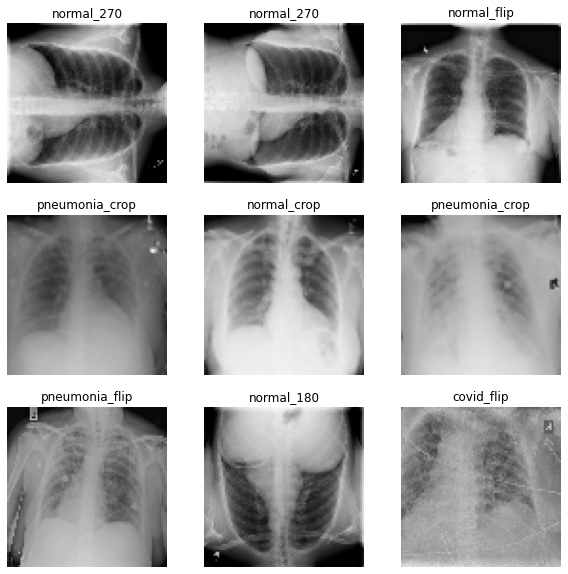

In [16]:
idxs = np.random.choice(X_train.shape[0], 9, replace=False)

imgs, labels = X_train[idxs], Y_train[idxs]

plt.figure(figsize=(10,10))
for i in range(imgs.shape[0]):
    img = np.squeeze(imgs[i])
    label = labels[i]

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(label)

## Train a ProtoNet

The embedding architecture of a `ProtoNet` is stated as follow.

In [17]:
model = protoNet(input_shape=(84,84,3))
model.encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 84, 84, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 84, 84, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 84, 84, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 42, 42, 64)        256 

### Some Utilities

In [18]:
def plot():
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(train_loss_history)
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.subplot(2,1,2)
    plt.plot(train_acc_history)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

In [19]:
def get_optimizer(params):
    num_steps_per_epoch = X_train.shape[0]//(params['n_way']*(params['n_shot']+params['n_query']))
    boundaries = [num_steps_per_epoch*25, num_steps_per_epoch*50, num_steps_per_epoch*75, num_steps_per_epoch*100]

    lr = 1e-3
    values = [lr, lr/2, (lr/2)/2, ((lr/2)/2)/2, (((lr/2)/2)/2)/2]

    learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
    
    return num_steps_per_epoch, optimizer

### Train 10-way 5-shot 15-query

Note that we used a GPU to train. The training took about 19 mins. 

In [20]:
TRAIN_PARAMS = {'n_way':10, 'n_shot':5, 'n_query':15}
num_steps_per_epoch, optimizer = get_optimizer(TRAIN_PARAMS)

EPOCHS = 120

print('Train on %s for %d epochs (%d steps per epoch)' %(TRAIN_PARAMS, EPOCHS, num_steps_per_epoch))

Train on {'n_way': 10, 'n_shot': 5, 'n_query': 15} for 120 epochs (36 steps per epoch)


In [21]:
t1 = time.time()
train_loss_history, train_acc_history = train(
    protonet=model, 
    optimizer=optimizer, 
    X=X_train, 
    Y=Y_train, 
    params=TRAIN_PARAMS, 
    epochs=EPOCHS, 
    print_every=num_steps_per_epoch//2
)
t2 = time.time()

print('\nTime %.1f mins' %float((t2-t1)/60))


Start of epoch 1
Instructions for updating:
Use tf.identity instead.
Step 0, Loss 2.1682, ACC 0.4667, lr 1.000000e-03
Step 18, Loss 1.3303, ACC 0.5249, lr 1.000000e-03
Epoch 1, Loss 1.1808, ACC 0.5609

Start of epoch 2
Step 36, Loss 1.1487, ACC 0.5800, lr 1.000000e-03
Step 54, Loss 1.0592, ACC 0.5877, lr 1.000000e-03
Epoch 2, Loss 0.9934, ACC 0.6144

Start of epoch 3
Step 72, Loss 0.8573, ACC 0.6400, lr 1.000000e-03
Step 90, Loss 0.9479, ACC 0.6211, lr 1.000000e-03
Epoch 3, Loss 0.9196, ACC 0.6352

Start of epoch 4
Step 108, Loss 1.1513, ACC 0.5733, lr 1.000000e-03
Step 126, Loss 0.8505, ACC 0.6635, lr 1.000000e-03
Epoch 4, Loss 0.8399, ACC 0.6639

Start of epoch 5
Step 144, Loss 0.7145, ACC 0.7200, lr 1.000000e-03
Step 162, Loss 0.7690, ACC 0.6888, lr 1.000000e-03
Epoch 5, Loss 0.7672, ACC 0.6974

Start of epoch 6
Step 180, Loss 0.9985, ACC 0.5800, lr 1.000000e-03
Step 198, Loss 0.7799, ACC 0.6870, lr 1.000000e-03
Epoch 6, Loss 0.7735, ACC 0.6907

Start of epoch 7
Step 216, Loss 0.46

Step 1836, Loss 0.3299, ACC 0.8867, lr 2.500000e-04
Step 1854, Loss 0.3184, ACC 0.8751, lr 2.500000e-04
Epoch 52, Loss 0.3070, ACC 0.8820

Start of epoch 53
Step 1872, Loss 0.3833, ACC 0.8867, lr 2.500000e-04
Step 1890, Loss 0.2958, ACC 0.8825, lr 2.500000e-04
Epoch 53, Loss 0.2950, ACC 0.8806

Start of epoch 54
Step 1908, Loss 0.3252, ACC 0.8733, lr 2.500000e-04
Step 1926, Loss 0.2881, ACC 0.8881, lr 2.500000e-04
Epoch 54, Loss 0.2805, ACC 0.8919

Start of epoch 55
Step 1944, Loss 0.1506, ACC 0.9400, lr 2.500000e-04
Step 1962, Loss 0.2754, ACC 0.8968, lr 2.500000e-04
Epoch 55, Loss 0.2823, ACC 0.8941

Start of epoch 56
Step 1980, Loss 0.2017, ACC 0.9333, lr 2.500000e-04
Step 1998, Loss 0.2725, ACC 0.8965, lr 2.500000e-04
Epoch 56, Loss 0.2773, ACC 0.8961

Start of epoch 57
Step 2016, Loss 0.2269, ACC 0.8933, lr 2.500000e-04
Step 2034, Loss 0.3035, ACC 0.8758, lr 2.500000e-04
Epoch 57, Loss 0.3064, ACC 0.8796

Start of epoch 58
Step 2052, Loss 0.3177, ACC 0.8933, lr 2.500000e-04
Step 2

Step 3726, Loss 0.2026, ACC 0.9200, lr 6.250000e-05
Epoch 104, Loss 0.2081, ACC 0.9181

Start of epoch 105
Step 3744, Loss 0.2842, ACC 0.8733, lr 6.250000e-05
Step 3762, Loss 0.2058, ACC 0.9175, lr 6.250000e-05
Epoch 105, Loss 0.2098, ACC 0.9150

Start of epoch 106
Step 3780, Loss 0.2205, ACC 0.9267, lr 6.250000e-05
Step 3798, Loss 0.2268, ACC 0.9116, lr 6.250000e-05
Epoch 106, Loss 0.2083, ACC 0.9187

Start of epoch 107
Step 3816, Loss 0.3056, ACC 0.8800, lr 6.250000e-05
Step 3834, Loss 0.2131, ACC 0.9182, lr 6.250000e-05
Epoch 107, Loss 0.2136, ACC 0.9169

Start of epoch 108
Step 3852, Loss 0.0983, ACC 0.9800, lr 6.250000e-05
Step 3870, Loss 0.2348, ACC 0.9102, lr 6.250000e-05
Epoch 108, Loss 0.2276, ACC 0.9156

Start of epoch 109
Step 3888, Loss 0.1850, ACC 0.9133, lr 6.250000e-05
Step 3906, Loss 0.2131, ACC 0.9151, lr 6.250000e-05
Epoch 109, Loss 0.2111, ACC 0.9178

Start of epoch 110
Step 3924, Loss 0.1112, ACC 0.9800, lr 6.250000e-05
Step 3942, Loss 0.2121, ACC 0.9232, lr 6.25000

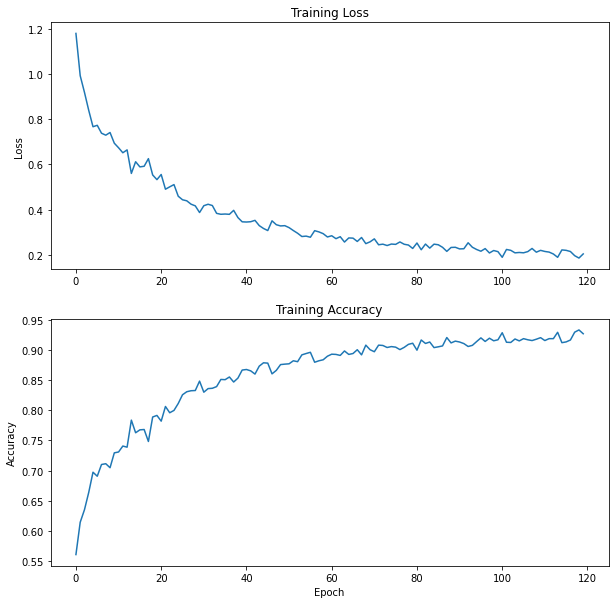

In [22]:
plot()

## Validate 3-way {5,50}-shot 15-query

### 5-shot

In [23]:
VAL_PARAMS = {'n_way':3, 'n_shot':5, 'n_query':15}

t1 = time.time()
loss_epochs, acc_epochs, ppv_steps, tpr_steps = test(
    protonet=model, 
    X=X_val, 
    Y=Y_val, 
    params=VAL_PARAMS, 
    epochs=100, 
    display_ppv_tpr=True
)
t2 = time.time()

print('\nTime %.1f mins' %float((t2-t1)/60))


Start of epoch 1
Epoch 1, Loss 0.5738, ACC 0.8000

Start of epoch 2
Epoch 2, Loss 0.5304, ACC 0.8044

Start of epoch 3
Epoch 3, Loss 0.3875, ACC 0.8667

Start of epoch 4
Epoch 4, Loss 0.5454, ACC 0.8000

Start of epoch 5
Epoch 5, Loss 0.6246, ACC 0.7333

Start of epoch 6
Epoch 6, Loss 0.4702, ACC 0.8622

Start of epoch 7
Epoch 7, Loss 0.4278, ACC 0.8400

Start of epoch 8
Epoch 8, Loss 0.5092, ACC 0.7822

Start of epoch 9
Epoch 9, Loss 0.4787, ACC 0.8044

Start of epoch 10
Epoch 10, Loss 0.5351, ACC 0.8000

Start of epoch 11
Epoch 11, Loss 0.5066, ACC 0.8044

Start of epoch 12
Epoch 12, Loss 0.4493, ACC 0.8400

Start of epoch 13
Epoch 13, Loss 0.4292, ACC 0.8178

Start of epoch 14
Epoch 14, Loss 0.5498, ACC 0.7956

Start of epoch 15
Epoch 15, Loss 0.4280, ACC 0.8578

Start of epoch 16
Epoch 16, Loss 0.5595, ACC 0.7956

Start of epoch 17
Epoch 17, Loss 0.4921, ACC 0.8222

Start of epoch 18
Epoch 18, Loss 0.5343, ACC 0.7822

Start of epoch 19
Epoch 19, Loss 0.5486, ACC 0.8000

Start of e

In [24]:
print('PPVs:')
ppv = np.mean(ppv_steps, axis=0)
for label, value in zip(np.unique(Y_val), ppv):
    print(label, value)

PPVs:
covid 0.8887872614526708
normal 0.8043401840645552
pneumonia 0.7664579862000225


In [25]:
print('TPRs:')
tpr = np.mean(tpr_steps, axis=0)
for label, value in zip(np.unique(Y_val), tpr):
    print(label, value)

TPRs:
covid 0.8832000000000034
normal 0.7834666666666703
pneumonia 0.7449333333333362


### 50-shot

In [26]:
VAL_PARAMS = {'n_way':3, 'n_shot':50, 'n_query':15}

t1 = time.time()
loss_epochs, acc_epochs, ppv_steps, tpr_steps = test(
    protonet=model, 
    X=X_val, 
    Y=Y_val, 
    params=VAL_PARAMS, 
    epochs=100, 
    display_ppv_tpr=True
)
t2 = time.time()

print('\nTime %.1f mins' %float((t2-t1)/60))


Start of epoch 1
Epoch 1, Loss 0.3967, ACC 0.8556

Start of epoch 2
Epoch 2, Loss 0.4836, ACC 0.8667

Start of epoch 3
Epoch 3, Loss 0.4397, ACC 0.8222

Start of epoch 4
Epoch 4, Loss 0.3216, ACC 0.9111

Start of epoch 5
Epoch 5, Loss 0.3429, ACC 0.9000

Start of epoch 6
Epoch 6, Loss 0.2757, ACC 0.9556

Start of epoch 7
Epoch 7, Loss 0.3694, ACC 0.8333

Start of epoch 8
Epoch 8, Loss 0.3993, ACC 0.8556

Start of epoch 9
Epoch 9, Loss 0.3619, ACC 0.8889

Start of epoch 10
Epoch 10, Loss 0.3887, ACC 0.8444

Start of epoch 11
Epoch 11, Loss 0.3935, ACC 0.8444

Start of epoch 12
Epoch 12, Loss 0.3049, ACC 0.9333

Start of epoch 13
Epoch 13, Loss 0.5013, ACC 0.8222

Start of epoch 14
Epoch 14, Loss 0.3549, ACC 0.8778

Start of epoch 15
Epoch 15, Loss 0.3466, ACC 0.8444

Start of epoch 16
Epoch 16, Loss 0.3307, ACC 0.8778

Start of epoch 17
Epoch 17, Loss 0.3649, ACC 0.8444

Start of epoch 18
Epoch 18, Loss 0.3824, ACC 0.8444

Start of epoch 19
Epoch 19, Loss 0.3121, ACC 0.8889

Start of e

In [27]:
print('PPVs:')
ppv = np.mean(ppv_steps, axis=0)
for label, value in zip(np.unique(Y_val), ppv):
    print(label, value)

PPVs:
covid 0.9611919844861022
normal 0.8482569001346089
pneumonia 0.8090863038750034


In [28]:
print('TPRs:')
tpr = np.mean(tpr_steps, axis=0)
for label, value in zip(np.unique(Y_val), tpr):
    print(label, value)

TPRs:
covid 0.9056666666666673
normal 0.8433333333333336
pneumonia 0.8423333333333342


## Test 3-way 50-shot 15-query

Since 50-shot has the best validation performance, we report the final result on the test set using 50-shot, 3-way and 15-query. Note that we used a GPU to test and it took about 2 mins.

In [29]:
TEST_PARAMS = {'n_way':3, 'n_shot':50, 'n_query':15}

t1 = time.time()
loss_epochs, acc_epochs, ppv_steps, tpr_steps = test(
    protonet=model, 
    X=X_test, 
    Y=Y_test, 
    params=TEST_PARAMS, 
    epochs=100, 
    display_ppv_tpr=True
)
t2 = time.time()

print('\nTime %.1f mins' %float((t2-t1)/60))


Start of epoch 1
Epoch 1, Loss 0.3625, ACC 0.8444

Start of epoch 2
Epoch 2, Loss 0.4946, ACC 0.8173

Start of epoch 3
Epoch 3, Loss 0.4661, ACC 0.8099

Start of epoch 4
Epoch 4, Loss 0.3630, ACC 0.8691

Start of epoch 5
Epoch 5, Loss 0.3971, ACC 0.8395

Start of epoch 6
Epoch 6, Loss 0.4762, ACC 0.8074

Start of epoch 7
Epoch 7, Loss 0.4144, ACC 0.8469

Start of epoch 8
Epoch 8, Loss 0.3979, ACC 0.8469

Start of epoch 9
Epoch 9, Loss 0.4649, ACC 0.8173

Start of epoch 10
Epoch 10, Loss 0.3654, ACC 0.8716

Start of epoch 11
Epoch 11, Loss 0.4065, ACC 0.8198

Start of epoch 12
Epoch 12, Loss 0.3877, ACC 0.8617

Start of epoch 13
Epoch 13, Loss 0.4210, ACC 0.8370

Start of epoch 14
Epoch 14, Loss 0.3971, ACC 0.8444

Start of epoch 15
Epoch 15, Loss 0.4724, ACC 0.8148

Start of epoch 16
Epoch 16, Loss 0.3550, ACC 0.8617

Start of epoch 17
Epoch 17, Loss 0.3918, ACC 0.8296

Start of epoch 18
Epoch 18, Loss 0.4413, ACC 0.8395

Start of epoch 19
Epoch 19, Loss 0.4288, ACC 0.8321

Start of e

### The Final Results

In [30]:
print('PPVs:')
ppv = np.mean(ppv_steps, axis=0)
for label, value in zip(np.unique(Y_test), ppv):
    print(label, value)

PPVs:
covid 0.885323824242682
normal 0.8494707001804513
pneumonia 0.7992036227770163


In [31]:
print('TPRs:')
tpr = np.mean(tpr_steps, axis=0)
for label, value in zip(np.unique(Y_test), tpr):
    print(label, value)

TPRs:
covid 0.8452592592592565
normal 0.868666666666662
pneumonia 0.7979259259259248
